In [85]:
from sqlalchemy.ext.declarative import declarative_base
from sqlalchemy import Column, Integer, String, DateTime, REAL
from sqlalchemy.orm import sessionmaker
import sqlalchemy

import MySQLdb

import jsonify
import json
from ipywidgets import widgets
import pickle
import re

In [69]:
%matplotlib inline

In [103]:
colors = pd.read_csv('data/codis_info.csv')

In [104]:
from PIL import Image, ImageDraw 
def view_color(rgb):
    w, h = 5, 1

    img = Image.new('RGB',(w,h), rgb)

    plt.grid(False)
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])
    plt.show()
    
def rgb2hex(r, g, b):
    return '#%02x%02x%02x' % ( r, g, b)

def hex2rgb(h): 
    h = h.lstrip('#')
    return tuple(int(h[i:i+2], 16) for i in (0, 2 ,4))

def rgb2hsv(r, g, b):
    r, g, b = r/255.0, g/255.0, b/255.0
    mx = max(r, g, b)
    mn = min(r, g, b)
    df = mx-mn
    if mx == mn:
        h = 0
    elif mx == r:
        h = (60 * ((g-b)/df) + 360) % 360
    elif mx == g:
        h = (60 * ((b-r)/df) + 120) % 360
    elif mx == b:
        h = (60 * ((r-g)/df) + 240) % 360
    if mx == 0:
        s = 0
    else:
        s = df/mx
    v = mx
    return np.array([h, s, v])

In [105]:
# float -> int로 변환 (rgb값은 정수)
p = re.compile("_[RGB]")
for col in colors.columns:  
    if p.search(col): 
        colors[col] = colors[col].astype(int)

### hsv 분포 보기

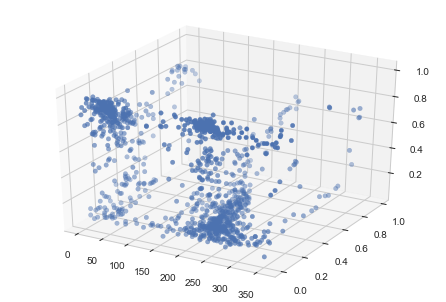

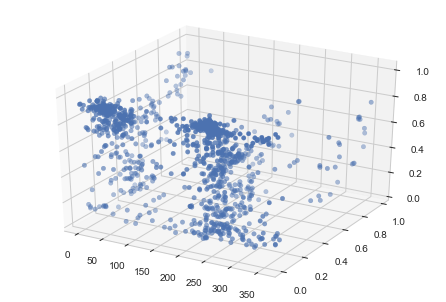

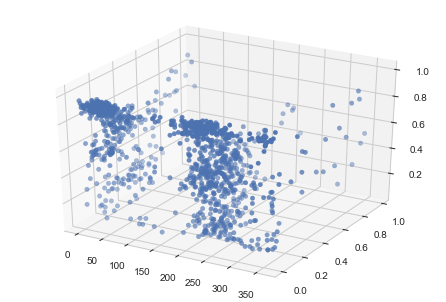

In [112]:
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(colors.color1_H, colors.color1_S, colors.color1_V, cmap=plt.cm.jet)
plt.show()

fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(colors.color2_H, colors.color2_S, colors.color2_V, cmap=plt.cm.jet)
plt.show()

fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(colors.color3_H, colors.color3_S, colors.color3_V, cmap=plt.cm.jet)
plt.show()

In [ ]:
widgets.interact(plot_pca, azim=widgets.IntSlider(min=0,max=180,step=10,value=0));

In [16]:
rgb_hex_ls = []
for i in range(len(colors)):
    row = colors.iloc[i].astype(int)
    c1 = rgb2hex( row['color1_R'], row['color1_G'], row['color1_B'])
    c2 = rgb2hex( row['color2_R'], row['color2_G'], row['color2_B'])
    c3 = rgb2hex( row['color3_R'], row['color3_G'], row['color3_B'])  
    rgb_hex_ls.append([c1, c2, c3])

In [17]:
colordf = pd.DataFrame(rgb_hex_ls) 

In [18]:
mc1 = pd.concat([colors['name'], colordf[0], colors['color1_ratio']], axis=1).rename(columns={0:'color','color1_ratio':'ratio'})
mc2 = pd.concat([colors['name'], colordf[1], colors['color2_ratio']], axis=1).rename(columns={1:'color','color2_ratio':'ratio'})
mc3 = pd.concat([colors['name'], colordf[2], colors['color3_ratio']], axis=1).rename(columns={2:'color','color3_ratio':'ratio'})

In [19]:
mapping_codi_color = pd.concat([mc1,mc2,mc3])

In [20]:
color_df = pd.DataFrame(list(set(mapping_codi_color['color'])), columns=['color'])

In [21]:
with open('pw.pw', 'rb') as f:
    pw = pickle.load(f)

ip = '127.0.0.1'
db = 'codi'

In [22]:
engine = sqlalchemy.create_engine("mysql+mysqldb://root:"+pw+"@"+ip+"/"+db)

In [106]:
# 색상 hex 값 저장, rgb 대신 hex가 다루기 편하다
color_df.to_sql(name='colors', con=engine, if_exists='replace', index_label='id')

In [25]:
# 코디와 색상 매핑 정보
color_df['id2'] = color_df.index

In [27]:
mapping_codi_color = mapping_codi_color.merge(right=color_df, how='inner', on='color')
mapping_codi_color = mapping_codi_color.drop(columns=['color']).rename(columns={'id2':'id_color', 'name':'id_codi'})

In [121]:
# 코디와 색상 매핑 정보
mapping_codi_color.to_sql(name='mapping_codi_color', con=engine, if_exists='replace', index_label='id')